In [1]:
import tensorflow as tf
import keras as k
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

Using TensorFlow backend.


In [2]:
! python --version

Python 2.7.5


In [3]:
tf.__version__

'1.13.1'

In [4]:
k.__version__

'2.2.4'

In [5]:
read_all_imgs = []
for img_path in glob.glob("/data/hollatz/deep_learning/datasets/try1_original/png/*.png"):
    img_frame = Image.open(img_path)
    split_path = img_path.split("/")
    split_format = split_path[-1].split(".")
    split_num = split_format[0].split("_")
    img_array = np.asarray(img_frame)
    img_array = img_array.reshape((img_array.shape[0], img_array.shape[1], 1))
    read_all_imgs.append((img_array, split_num[-1]))

In [6]:
from operator import itemgetter
sorted_all_imgs = sorted(read_all_imgs, key=itemgetter(1))
all_imgs = [ i for i,j in sorted_all_imgs]

In [7]:
df_labels = pd.read_csv('/data/hollatz/deep_learning/datasets/try1_original/categories1.txt', sep=' ', 
                        names=['quality', 'mosaic1', 'mosaic2'])
df_labels = df_labels.drop(['mosaic1', 'mosaic2'], axis=1)

In [8]:
df_labels.head()

,quality
fake_00001.png,good
fake_00002.png,weak
fake_00003.png,strong
fake_00004.png,weak
fake_00005.png,weak


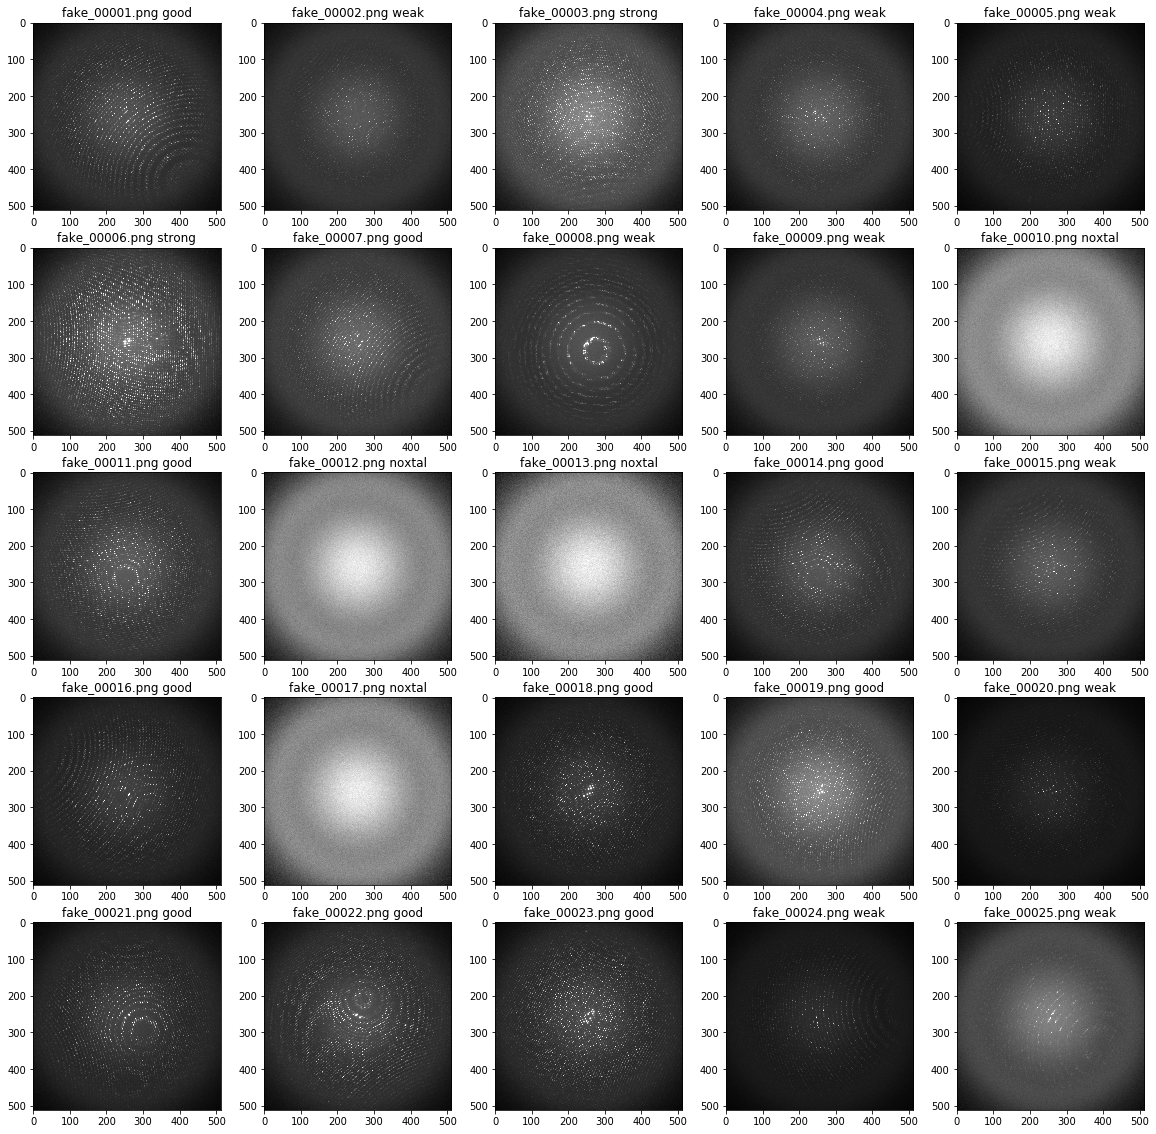

In [9]:
all_imgs = np.array(all_imgs)
unique_index = pd.Index(df_labels.index)

fig = plt.figure(figsize=(20,20))
for t, name in enumerate(unique_index[:25]):
    fig.add_subplot(5, 5, t+1)
    index = unique_index.get_loc(name)
    quality = df_labels.loc[name].quality
    plt.title(name + " " + quality)
    plt.imshow(all_imgs[index].reshape(all_imgs[index].shape[0], all_imgs[index].shape[1]), cmap='gray')
plt.show()


In [10]:
dummy = pd.get_dummies(df_labels.quality)
df_labels = df_labels.drop(['quality'], axis=1)
df_labels = pd.concat([df_labels, dummy], axis=1)
df_labels.head()

,blank,good,noxtal,strong,weak
fake_00001.png,0,1,0,0,0
fake_00002.png,0,0,0,0,1
fake_00003.png,0,0,0,1,0
fake_00004.png,0,0,0,0,1
fake_00005.png,0,0,0,0,1


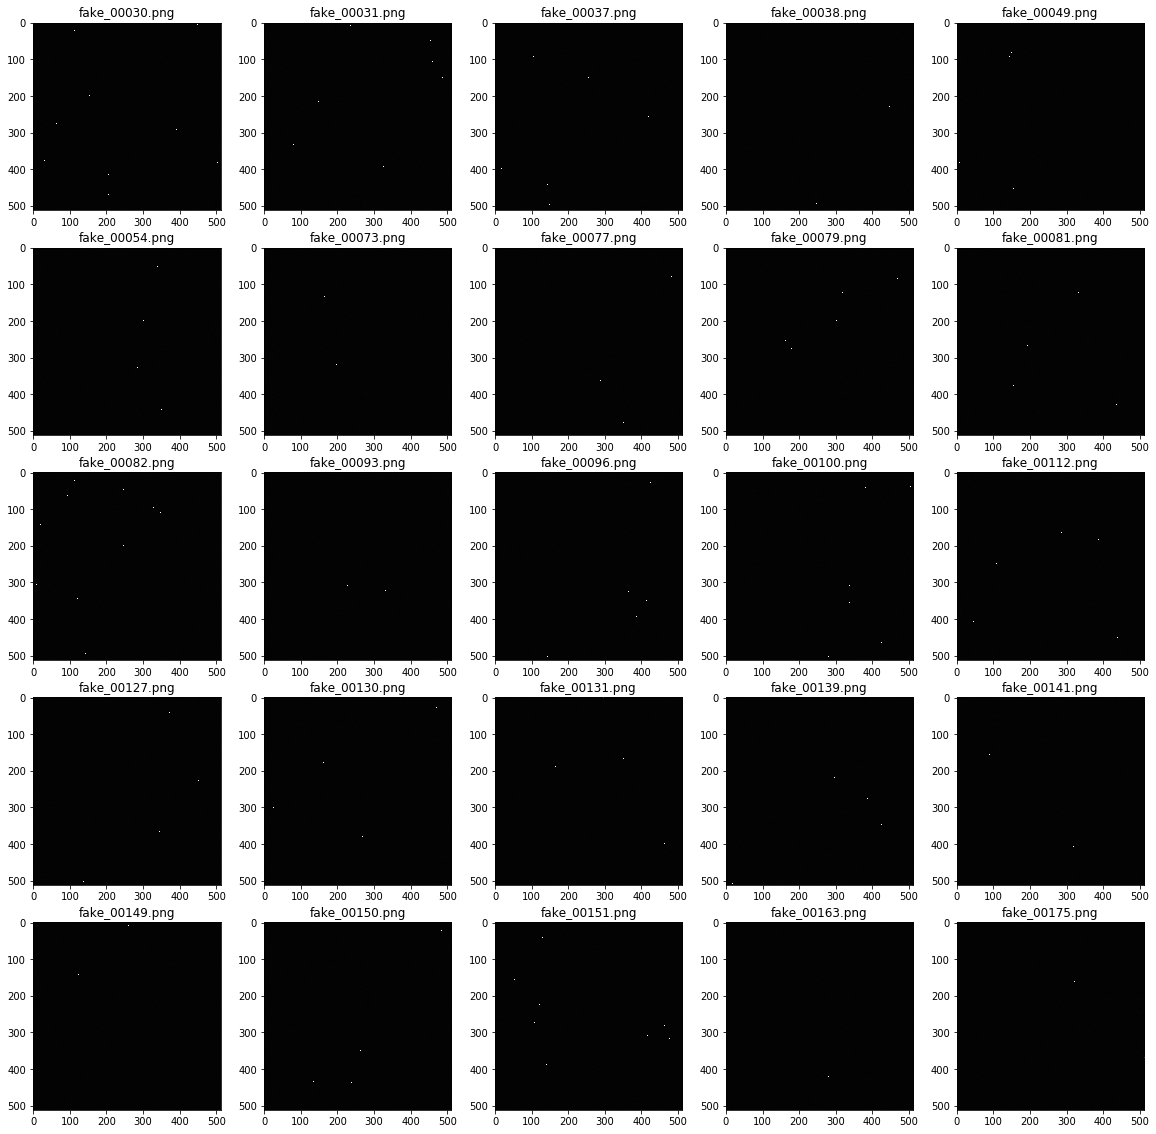

In [11]:
all_imgs = np.array(all_imgs)
unique_index = pd.Index(df_labels.index)
blank_true = df_labels[df_labels.blank == 1].index
noxtal_true = df_labels[df_labels.noxtal == 1].index

# displaying blank images to see the difference between blank and no-crystal(next codeblock)
fig = plt.figure(figsize=(20,20))
for t, name in enumerate(blank_true[:25]):
    fig.add_subplot(5, 5, t+1)
    index = unique_index.get_loc(name)
    plt.title(name)
    plt.imshow(all_imgs[index].reshape(all_imgs[index].shape[0], all_imgs[index].shape[1]), cmap='gray')
plt.show()

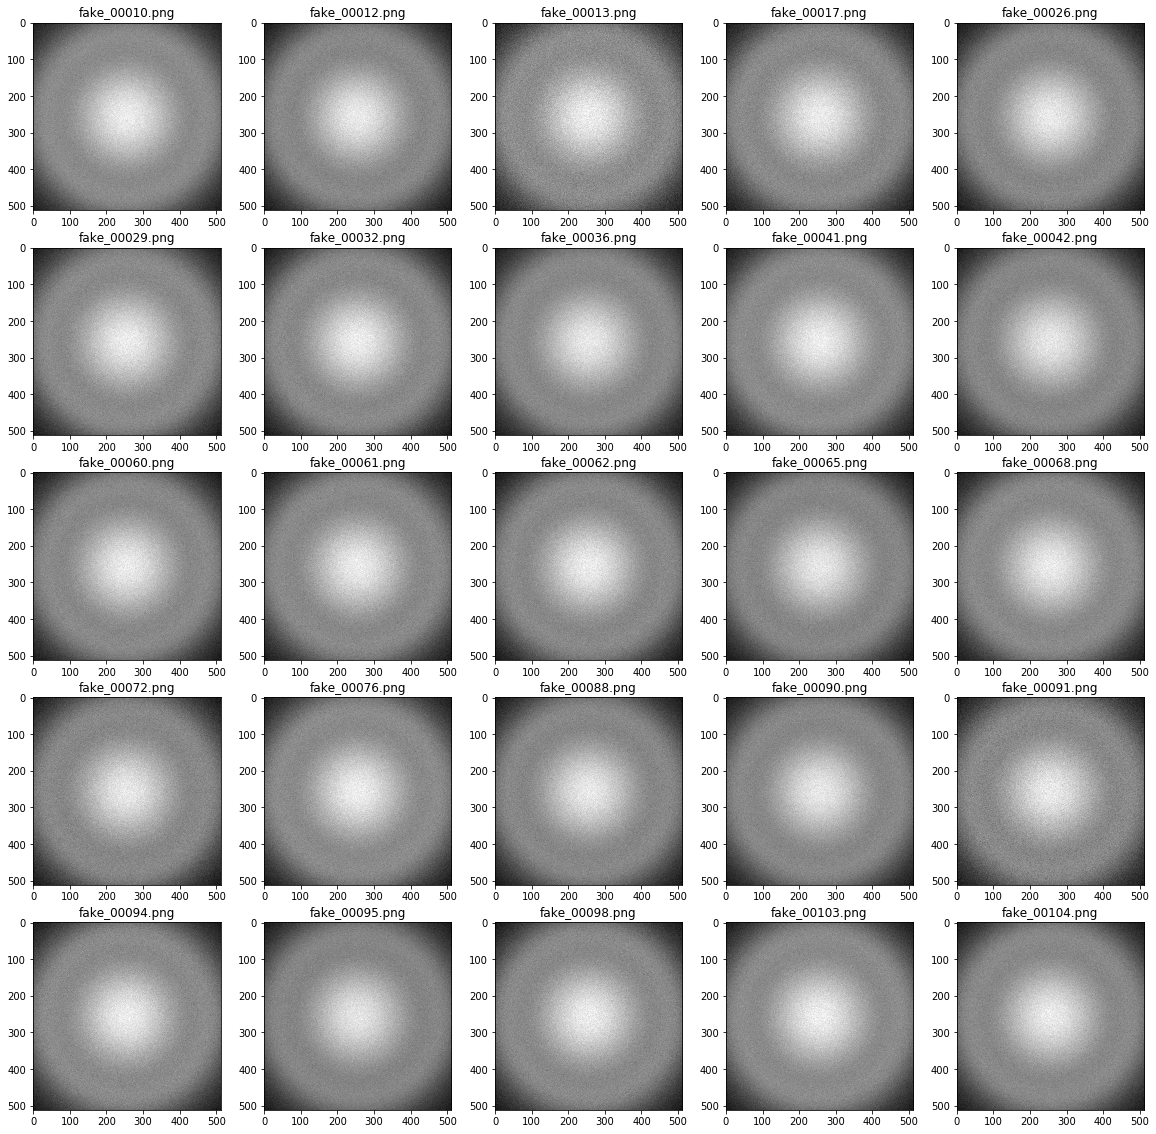

In [12]:
fig = plt.figure(figsize=(20,20))
for t, name in enumerate(noxtal_true[:25]):
    fig.add_subplot(5, 5, t+1)
    index = unique_index.get_loc(name)
    plt.title(name)
    plt.imshow(all_imgs[index].reshape(all_imgs[index].shape[0], all_imgs[index].shape[1]), cmap='gray')
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(all_imgs, df_labels, test_size=0.33, random_state=42)

In [14]:
y_train.head()

,blank,good,noxtal,strong,weak
fake_08479.png,0,0,1,0,0
fake_06912.png,0,0,0,0,1
fake_04706.png,0,0,1,0,0
fake_02653.png,0,0,0,0,1
fake_06649.png,0,0,0,0,1


In [15]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [16]:
print("Training Images: ")
print(X_train.shape)
print(y_train.shape)
print("\n Validation Images: ")
print(X_val.shape)
print(y_val.shape)
print("\n Test Images: ")
print(X_test.shape)
print(y_test.shape)

Training Images: 
(8308, 512, 512, 1)
(8308, 5)

 Validation Images: 
(2741, 512, 512, 1)
(2741, 5)

 Test Images: 
(1351, 512, 512, 1)
(1351, 5)


In [17]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    rescale=1./255)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [18]:
input_X = k.layers.Input(shape=(512, 512, 1), name="input")

base_model = k.applications.vgg16.VGG16(
    include_top=True, 
    weights=None, 
    input_tensor=input_X, 
    input_shape=(512, 512, 1), 
    pooling=max,
    classes=5)

model = k.Model(inputs=input_X, outputs=base_model.output)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, 512, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [20]:
model.compile(loss='categorical_crossentropy',
                   optimizer=k.optimizers.Adam(0.0001),
                   metrics=['acc'])

In [22]:
epochs = 20
batchsize = 32

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

train_gen = train_datagen.flow(X_train, y_train.to_numpy(), batchsize)
val_gen = train_datagen.flow(X_val, y_val.to_numpy(), batchsize)

In [23]:
# data is randomly shuffled at each epoch
# history object is a record of training and validation loss values and metrics values at successive epochs
history = model.fit_generator(train_gen, 
                    validation_data=val_gen,
                    steps_per_epoch=len(X_train) / batchsize,
                    validation_steps=len(X_val) / batchsize,
                    shuffle=True,
                    callbacks=[callback],
                    epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
259/259 [==============================] - 308s 1s/step - loss: 0.6442 - acc: 0.7185 - val_loss: 0.1909 - val_acc: 0.9379
Epoch 2/20
259/259 [==============================] - 272s 1s/step - loss: 0.1990 - acc: 0.9283 - val_loss: 0.1218 - val_acc: 0.9612
Epoch 3/20
259/259 [==============================] - 264s 1s/step - loss: 0.1232 - acc: 0.9523 - val_loss: 0.0890 - val_acc: 0.9660
Epoch 4/20
259/259 [==============================] - 263s 1s/step - loss: 0.1148 - acc: 0.9576 - val_loss: 0.1699 - val_acc: 0.9439
Epoch 5/20
259/259 [==============================] - 265s 1s/step - loss: 0.0942 - acc: 0.9655 - val_loss: 0.1238 - val_acc: 0.9564
Epoch 6/20
259/259 [==============================] - 262s 1s/step - loss: 0.0943 - acc: 0.9643 - val_loss: 0.0813 - val_acc: 0.9708
Epoch 7/20
259/259 [==============================] - 263s 1s/step - loss: 0.0909 - acc: 0.9657 - val_loss: 0.1209 - val_acc: 0.9528
Epoch 8/20
259/259 [=

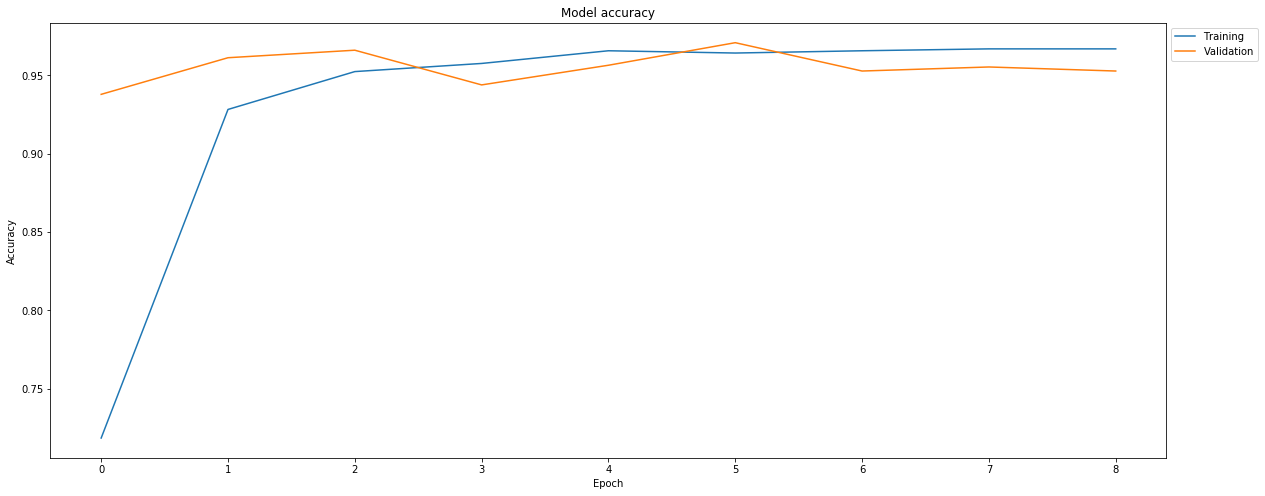

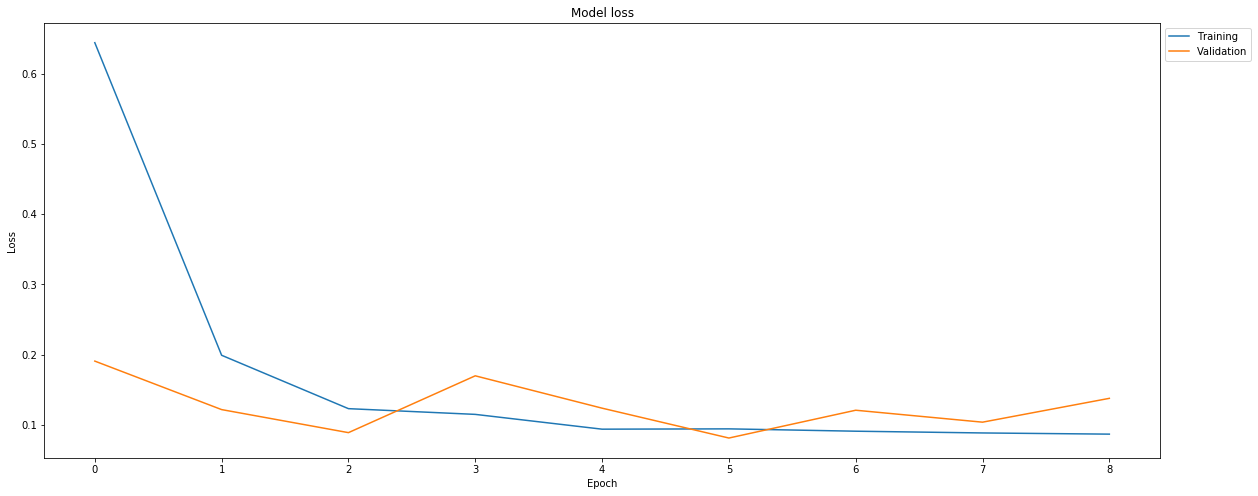

In [24]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left',
            bbox_to_anchor=(1, 1))
plt.show()

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [25]:
model.save('/mnt/home1/hollatz/projects/deep_learning/development/CSCL4622/VGG16_categorical_try1.h5')

[[205   0   0   0   1]
 [  0 167   0   0 100]
 [  0   0 376   0   1]
 [  0  83   0 159   0]
 [  0   0   0   0 259]]


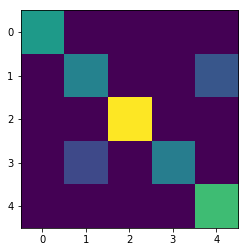

In [38]:
predictions = model.predict(X_test)
cm = metrics.confusion_matrix(predictions.argmax(axis=1), y_test.values.argmax(axis=1))
print(cm)
plt.imshow(cm)

The overall test accuracy is 86.30%.